## Load Data

Load the MNIST data, which comes pre-loaded with TensorFlow.

In [138]:
# Load pickled data
import pickle
import numpy as np

training_file = 'train.p'
validation_file = 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

n_train = len(X_train)
n_validation = len(X_validation)
n_test = len(X_test)

image_shape = X_train[0].shape

n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## Visualize Data

View a sample from the dataset.

You do not need to modify this section.

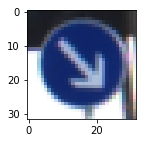

38


In [139]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

index = 15706 # random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(2,2))
plt.imshow(image)
plt.show()
print(y_train[index])
is_features_normal = False

## Data Augmentation

Functions to Rotate, Scale, Transform, Blur and Normalize existing Data

In [140]:
from scipy import ndimage
import cv2

def rotate(img):
    rows,cols,_ = img.shape
    axis_offset = random.uniform(-2,2)
    angle = random.uniform(-10,10)
    scale = random.uniform(0.95,1.05)
    M = cv2.getRotationMatrix2D((cols/2 + axis_offset,rows/2 + axis_offset),angle,scale)
    dst = cv2.warpAffine(img,M,(cols,rows))
    return np.reshape(dst,(32,32,1))

def affine_transform(img):
    rows,cols,_ = img.shape
    off = 4
    
    x_pt1 = np.array([cols/2, cols/4, 3*cols/4])
    y_pt1 = np.array([rows/4, 3*rows/4, 3*rows/4])
    x_offset = (np.random.rand(3) - 0.5) * off
    y_offset = (np.random.rand(3) - 0.5) * off
    x_pt2 = x_pt1 + x_offset
    y_pt2 = y_pt1 + y_offset

    pt1 = list(map(list, zip(*np.vstack((x_pt1, y_pt1)))))
    pt2 = list(map(list, zip(*np.vstack((x_pt2, y_pt2)))))
    pts1 = np.float32(pt1)
    pts2 = np.float32(pt2)

    M = cv2.getAffineTransform(pts1,pts2)
    dst = cv2.warpAffine(img,M,(cols,rows))
    return np.reshape(dst,(32,32,1))

def perspect(img):
    rows,cols,_ = img.shape
    off = 4
    
    x_pt1 = np.array([0, cols, 0, cols])
    y_pt1 = np.array([0, 0, rows, rows])
    x_offset = (np.random.rand(4) - 0.5) * off
    y_offset = (np.random.rand(4) - 0.5) * off
    x_pt2 = x_pt1 + x_offset
    y_pt2 = y_pt1 + y_offset

    pt1 = list(map(list, zip(*np.vstack((x_pt1, y_pt1)))))
    pt2 = list(map(list, zip(*np.vstack((x_pt2, y_pt2)))))
    pts1 = np.float32(pt1)
    pts2 = np.float32(pt2)

    M = cv2.getPerspectiveTransform(pts1,pts2)

    dst = cv2.warpPerspective(img,M,(32,32))
    return np.reshape(dst,(32,32,1))
    
def gaus_blur(img):
    kernel = np.ones((2,2),np.float32)/4
    dst = cv2.filter2D(img,-1,kernel)
    return np.reshape(dst,(32,32,1))

def eq_hist(img):
    img = np.reshape(img,(32,32)).astype('uint8')
    dst = cv2.equalizeHist(img)
    return np.reshape(dst,(32,32,1)).astype('float')

def normalize(image_data):
    return (image_data - 128)/ 128

## Convert to Grayscale

In [141]:
X_train_gray = np.mean(X_train, axis=3, keepdims=True)
X_test_gray = np.mean(X_test, axis=3, keepdims=True)
X_validation_gray = np.mean(X_validation, axis=3, keepdims=True)

## Visualizing the Data Augmentation Output

(32, 32)


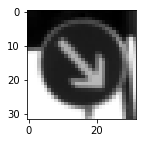

38
<class 'numpy.ndarray'>
(32, 32, 1)


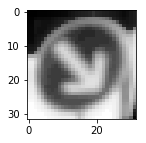

In [142]:
index = 15706 #random.randint(0, len(X_train_gray))
image = X_train_gray[index].squeeze()
print(image.shape)
plt.figure(figsize=(2,2))
plt.imshow(image, cmap="gray")
plt.show()
print(y_train[index])

image1 = eq_hist(gaus_blur(affine_transform(perspect(X_train_gray[index]))))
print(type(image))
print(image1.shape)
plt.figure(figsize=(2,2))
plt.imshow(image1.squeeze(), cmap="gray")
plt.show()

## Visualizing the Number of Training examples under each Label
Note that for few labels, we have very less data to train our model. This will result in lower prediction accuracy for those labels. Thus we will first augment our Data to atleast the mean of number of examples for each label. 

809.279069767


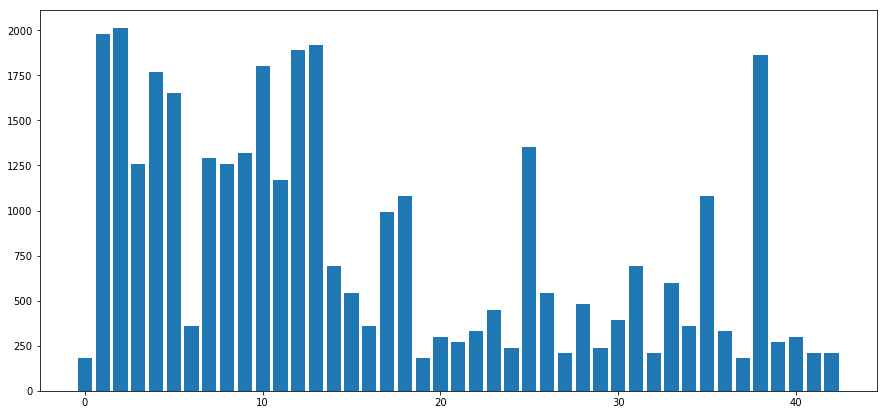

In [143]:
def plot_bar(data):
    count_sample = []
    for i in range(43):
        count_sample.append(sum(data == i))
    plt.figure(figsize=(15,7))
    plt.bar(np.arange(43), np.array(count_sample))
    return count_sample
                   
count = plot_bar(y_train)
mean = np.mean(count)
print(mean)
labels_below_mean = np.arange(43)[np.array(count) < np.mean(count)]

(16649, 32, 32, 1)


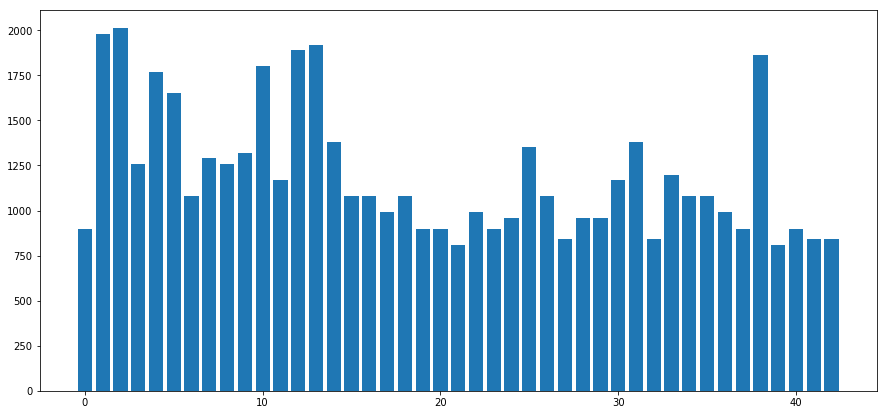

In [144]:
X_augmented = []
y_augmented = []
for l in labels_below_mean:
    X_to_augment = X_train_gray[y_train == l]
    repeat = int(mean / X_to_augment.shape[0])
    for r in range(repeat):
        for im in range(X_to_augment.shape[0]):
            X_augmented.append(eq_hist(gaus_blur(affine_transform(perspect(X_to_augment[im])))))
#             X_augmented.append(random_translate(random_scaling(random_warp(random_brightness(X_to_augment[im])))))
            y_augmented.append(l)
#     print("Label: {} Data: {} Repeat: {}".format(l, len(X_augmented), repeat))
print(np.array(X_augmented).shape)
X_train_augmented = np.concatenate((X_train_gray, np.array(X_augmented)), axis=0)
y_train_augmented = np.concatenate((y_train, np.array(y_augmented)), axis=0)
p = plot_bar(y_train_augmented)

## Data Normalization

In [145]:
if not is_features_normal:
    X_train_augmented = normalize(X_train_augmented)
    X_validation_gray = normalize(X_validation_gray)
    X_test_gray = normalize(X_test_gray)    
    is_features_normal = True

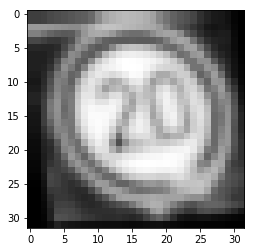

0


In [147]:
index = random.randint(0, X_train_augmented.shape[0])
image = X_train_augmented[index].squeeze()

# plt.figure(figsize=(2,2))
plt.imshow(image, cmap='gray')
plt.show()
print(y_train_augmented[index])

In [149]:
from sklearn.utils import shuffle

X_train_augmented, y_train_augmented = shuffle(X_train_augmented, y_train_augmented)

print(X_train_augmented.shape)

(51448, 32, 32, 1)


## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

In [150]:
import tensorflow as tf

EPOCHS = 30
BATCH_SIZE = 100

## Model Architecture

### Input
The architecture accepts a 32x32x1 image as input, since images are already converted to grayscale.

### Architecture
| Layer         		|     Description	        					| 
|:---------------------:|:---------------------------------------------:| 
| Input         		| 32x32x1 Grayscale image   							| 
| Convolution 4x4     	| 1x1 stride, valid padding, outputs 28x28x32 	|
| RELU					|												|
| Max pooling	      	| 2x2 stride,  outputs 14x14x32 				|
| Convolution 4x4     	| 1x1 stride, valid padding, outputs 10x10x128 	|
| RELU					|												|
| Max pooling	      	| 2x2 stride,  outputs 5x5x128 				|
| Fully connected		| outputs 3200x1024        									|
| RELU					|												|
| Fully connected		| outputs 1024x2048        									|
| RELU					|												|
| Dropout					|	keep_prob:0.5											|
| Fully connected		| outputs 2048x43        									|
| Softmax				|         									|

### Output
Return the result of the 3rd fully connected layer.

In [151]:
from tensorflow.contrib.layers import flatten

l1 = 0

def LeNet(x):   
    global l1
    mu = 0
    sigma = 0.1
    n_classes = 43
    keep_prob = 0.5
    
    weights = {
        'wc1': tf.Variable(tf.truncated_normal(shape=[4,4,1,32],mean=mu,stddev=sigma)),
        'wc2': tf.Variable(tf.truncated_normal(shape=[4,4,32,128],mean=mu,stddev=sigma)),
#         'wc21': tf.Variable(tf.truncated_normal(shape=[4,4,128,256],mean=mu,stddev=sigma)),
        'wc3': tf.Variable(tf.truncated_normal(shape=[5*5*128,1024],mean=mu,stddev=sigma)),
        'wc4': tf.Variable(tf.truncated_normal(shape=[1024,2048],mean=mu,stddev=sigma)),
        'wc5': tf.Variable(tf.truncated_normal(shape=[2048,n_classes],mean=mu,stddev=sigma))
    }
    
    biases = {
        'bc1': tf.Variable(tf.zeros(32)),
        'bc2': tf.Variable(tf.zeros(128)),
#         'bc21': tf.Variable(tf.zeros(256)),
        'bc3': tf.Variable(tf.zeros(1024)),
        'bc4': tf.Variable(tf.zeros(2048)),
        'bc5': tf.Variable(tf.zeros(n_classes))
    }
    
    pad = 'VALID'
    pad_pool = 'VALID'
    stride = [1,1,1,1]
    k_s = [1,2,2,1]
    
    l1 = tf.nn.conv2d(x,weights['wc1'],strides=stride,padding=pad)
    l1 = tf.nn.bias_add(l1,biases['bc1'])
    l1 = tf.nn.relu(l1)
    l1 = tf.nn.max_pool(l1,ksize=k_s,strides=k_s,padding=pad_pool)

    l2 = tf.nn.conv2d(l1,weights['wc2'],strides=stride,padding=pad)
    l2 = tf.nn.bias_add(l2,biases['bc2'])
    l2 = tf.nn.relu(l2)
    l2 = tf.nn.max_pool(l2,ksize=k_s,strides=k_s,padding=pad_pool)
        
    l2 = tf.contrib.layers.flatten(l2)
    
    l3 = tf.add(tf.matmul(l2,weights['wc3']),biases['bc3'])
    l3 = tf.nn.relu(l3)
    
    l4 = tf.add(tf.matmul(l3,weights['wc4']),biases['bc4'])
    l4 = tf.nn.relu(l4)
    l4 = tf.nn.dropout(l4, keep_prob=keep_prob)    
    
    logits = tf.add(tf.matmul(l4,weights['wc5']),biases['bc5'])
    
    return logits

## Features and Labels

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.


In [152]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

In [153]:
rate = 0.0008
# global_step = tf.Variable(0, trainable=False)
# starter_learning_rate = 0.01
# learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
#                                            100000, 0.96, staircase=True)

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [154]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

In [155]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_augmented)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_augmented, y_train_augmented = shuffle(X_train_augmented, y_train_augmented)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_augmented[offset:end], y_train_augmented[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        validation_accuracy = evaluate(X_validation_gray, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.868

EPOCH 2 ...
Validation Accuracy = 0.918

EPOCH 3 ...
Validation Accuracy = 0.915

EPOCH 4 ...
Validation Accuracy = 0.934

EPOCH 5 ...
Validation Accuracy = 0.929

EPOCH 6 ...
Validation Accuracy = 0.922

EPOCH 7 ...
Validation Accuracy = 0.926

EPOCH 8 ...
Validation Accuracy = 0.918

EPOCH 9 ...
Validation Accuracy = 0.946

EPOCH 10 ...
Validation Accuracy = 0.956

EPOCH 11 ...
Validation Accuracy = 0.951

EPOCH 12 ...
Validation Accuracy = 0.958

EPOCH 13 ...
Validation Accuracy = 0.954

EPOCH 14 ...
Validation Accuracy = 0.937

EPOCH 15 ...
Validation Accuracy = 0.956

EPOCH 16 ...
Validation Accuracy = 0.945

EPOCH 17 ...
Validation Accuracy = 0.964

EPOCH 18 ...
Validation Accuracy = 0.951

EPOCH 19 ...
Validation Accuracy = 0.961

EPOCH 20 ...
Validation Accuracy = 0.953

EPOCH 21 ...
Validation Accuracy = 0.956

EPOCH 22 ...
Validation Accuracy = 0.961

EPOCH 23 ...
Validation Accuracy = 0.956

EPOCH 24 ...
Validation Accura

## Evaluate the Model on Training and Test Set

In [168]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    train_accuracy = evaluate(X_train_augmented, y_train_augmented)
    print("Training Set Accuracy = {:.3f}".format(train_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Training Set Accuracy = 0.995


In [156]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_gray, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 0.948


## Testing the model on a few more random Traffic signs 

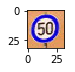

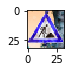

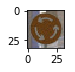

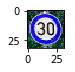

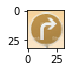

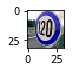

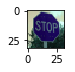

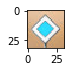

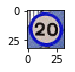

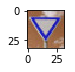

In [158]:
from glob import glob

my_test_images = []

for fn in glob('./mytest/*.jpg'):
    im = cv2.imread(fn)
    my_test_images.append(im)

my_images = np.array((my_test_images))
my_labels = np.array([2,25,40,1,33,8,14,12,0,13])
my_test_gray = np.mean(my_images, axis=3, keepdims=True)
my_test_norm = normalize(my_test_gray)

for i in range(my_images.shape[0]):
    plt.subplot(5,5,i+1)
    plt.imshow(my_images[i])
    plt.show()

In [197]:
scores = tf.nn.softmax(logits)
top_scores = tf.nn.top_k(scores, k=5)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    my_accuracy = evaluate(my_test_norm, my_labels)
    all_scores = sess.run(scores, feed_dict={x: my_test_norm})
    top_five = sess.run(top_scores, feed_dict={x: my_test_norm})

print(my_accuracy)

INFO:tensorflow:Restoring parameters from ./lenet
0.899999976158


In [198]:
print(top_five.indices)
print(top_five.values)
[2,25,40,1,33,8,14,12,0,13]

[[ 2  1 39 29 38]
 [25 24 30 11 26]
 [40 12 13 38 32]
 [ 1  0  2  3  4]
 [33 37 39 35 21]
 [ 0  1  5 40 38]
 [38 14  3 17 35]
 [12  0  1  2  3]
 [ 0  3  6 29 16]
 [13  0  1  2  3]]
[[  1.00000000e+00   4.35791647e-27   2.04174774e-30   1.67803568e-30
    2.97289868e-32]
 [  1.00000000e+00   3.81068593e-10   1.05500149e-13   9.35857693e-16
    2.72417525e-17]
 [  1.00000000e+00   2.93249064e-10   2.22213456e-10   2.85895214e-11
    5.93786793e-13]
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.00000000e+00   1.70946736e-31   1.09972979e-33   2.82017166e-35
    2.47316632e-36]
 [  8.89052689e-01   1.08010881e-01   1.49268250e-03   9.05096065e-04
    3.16681166e-04]
 [  9.99294162e-01   6.63201732e-04   3.00351949e-05   6.77168964e-06
    5.73186389e-06]
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  9.99079943e-01   9.19892220e-04   9.28092305e-08   1.46641144e-09
    1.18644441e-10]
 [  1.000

[2, 25, 40, 1, 33, 8, 14, 12, 0, 13]

In [199]:
import csv

signs = []

with open('signnames.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        if row[0] not in 'ClassId':
            signs.append(row[1])

signs = np.array(signs)

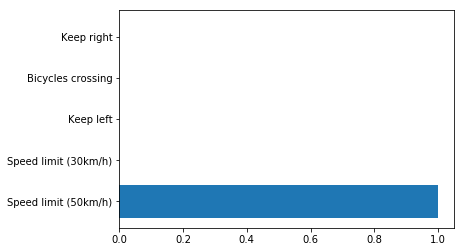

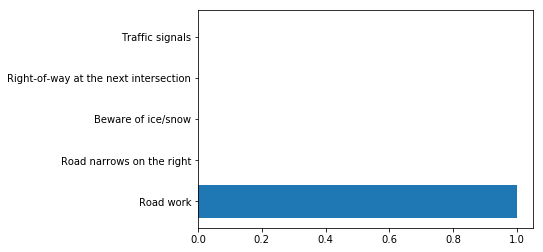

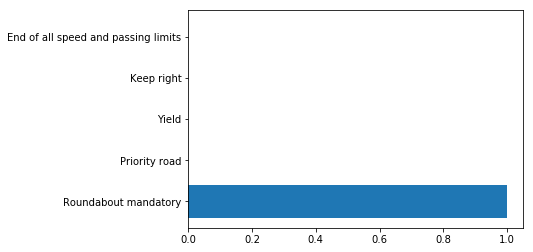

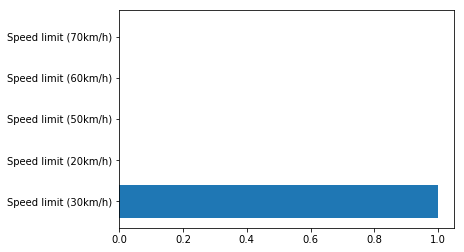

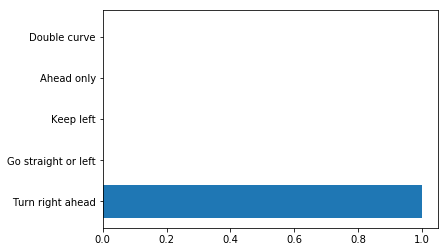

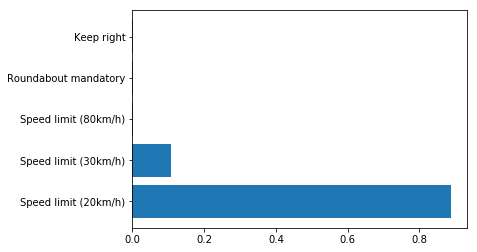

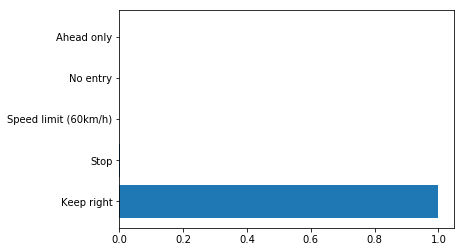

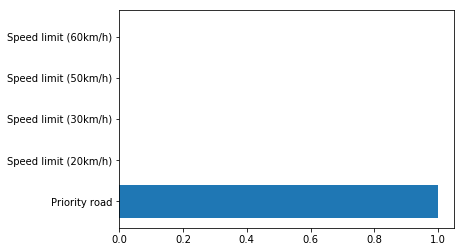

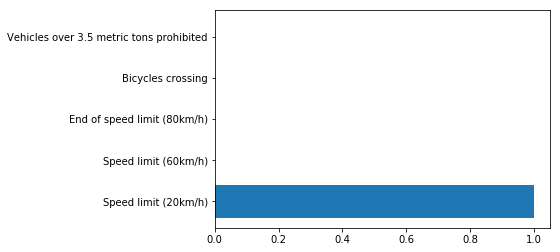

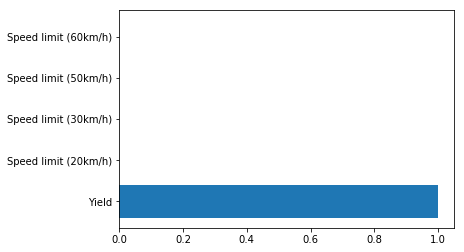

In [201]:
import matplotlib.pyplot as plt

for i in range(10):
    fig, ax = plt.subplots()
    ax.barh(np.arange(len(top_five.indices[i])), (top_five.values[i]))
    ax.set_yticks(np.arange(len(top_five.indices[i])))
    ax.set_yticklabels(labels=signs[top_five.indices[i]])

In [163]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

INFO:tensorflow:Restoring parameters from ./lenet


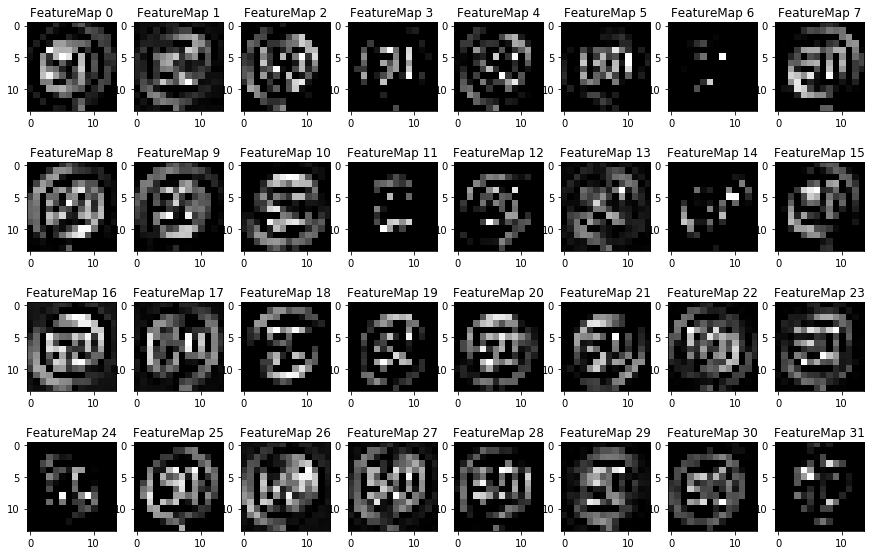

In [164]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    outputFeatureMap(my_test_norm,l1)